In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()
#gec.load_gp_datas("./gp_datas.json")


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]
np.random.seed(101)
ind = np.random.uniform(0, 1, X.shape[0]) <0.5
X = X[ind,:]
y = y[ind]

X_pos = X[y==1,:]
y_pos = y[y==1]

X_reweighted = np.concatenate([X] + [X_pos]*3, axis=0)
y_reweighted = np.concatenate([y] + [y_pos]*3)


print(X_reweighted.shape)

(30488, 48)


/tmp/ipykernel_45044/1527586109.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_45044/1527586109.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [3]:
gec.fit(X_reweighted, y_reweighted, 10, 2, "/home/leon/projects/100gecs/notebooks/gec_fitting.json")

100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


GEC(random_state=101)

In [4]:
gec.serialise("/home/leon/projects/100gecs/notebooks/gec.json")

In [10]:
gec = GEC.deserialise("/home/leon/projects/100gecs/notebooks/gec.json", X, y)

In [11]:
gec.fit(X_reweighted, y_reweighted, 4)

100%|██████████| 4/4 [00:19<00:00,  4.76s/it]


GEC(random_state=101)

In [12]:
gec.gec_iter

14

In [13]:
gec.best_params_

{'boosting': 'dart',
 'num_leaves': 14,
 'learning_rate': 0.018305031046050954,
 'n_estimators': 20,
 'max_bin': 900,
 'max_depth': 250,
 'lambda_l1': 0.9012919512394326,
 'lambda_l2': 0.11213700028500526,
 'min_data_in_leaf': 44,
 'feature_fraction': 0.16999999999999998,
 'verbosity': -1}

In [14]:
gec.best_scores_gec

{'search': 0.6523878551699408,
 'grid': 0.6519286279836914,
 'grid_from_search': 0.6519286279836914}

In [16]:
print({k:(np.mean(v["output"]), np.max(v["output"]), len(v["output"])) for k, v in gec.gp_datas.items()})

{'gbdt-yes_bagging': (0.6282593803015699, 0.6503827537659795, 4), 'gbdt-no_bagging': (0.5545765538484495, 0.5545765538484495, 1), 'dart-yes_bagging': (0.637359663090264, 0.6409346938996566, 2), 'dart-no_bagging': (0.6280352235856594, 0.6523878551699408, 5), 'rf-yes_bagging': (0.6097271626590104, 0.624143582223417, 2)}


/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


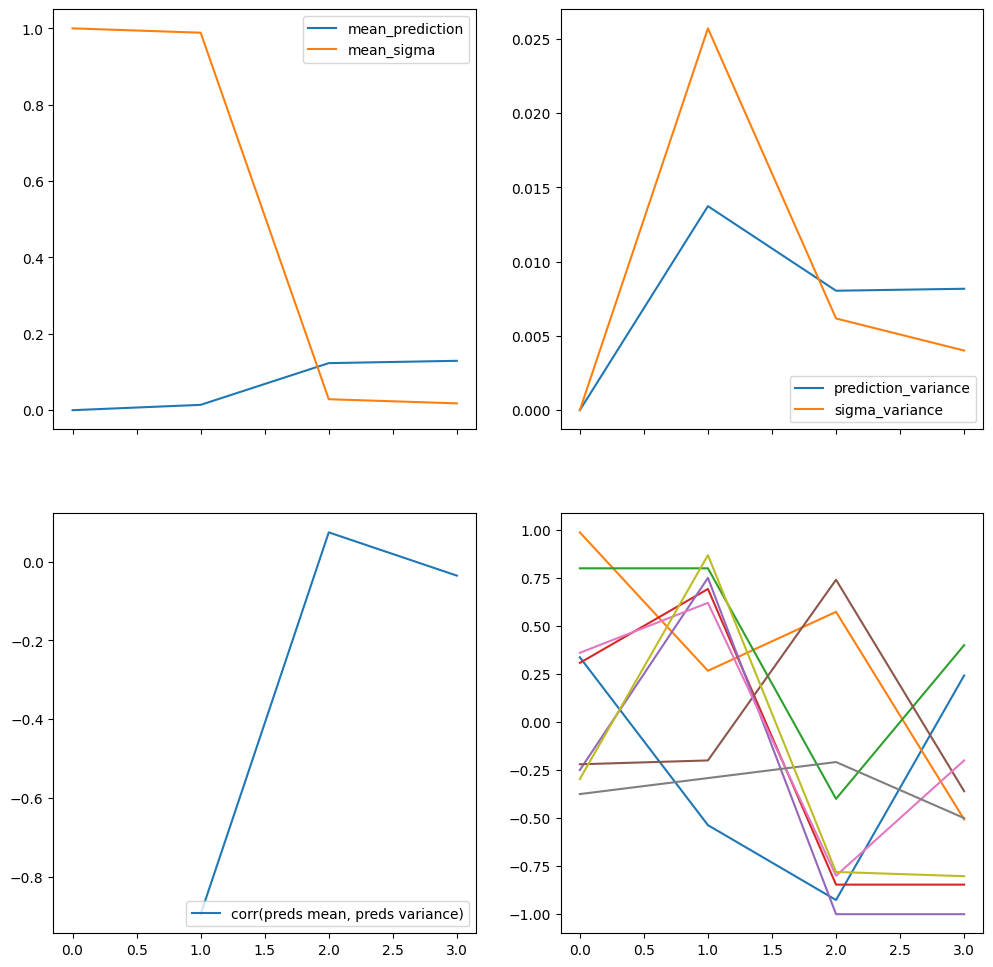

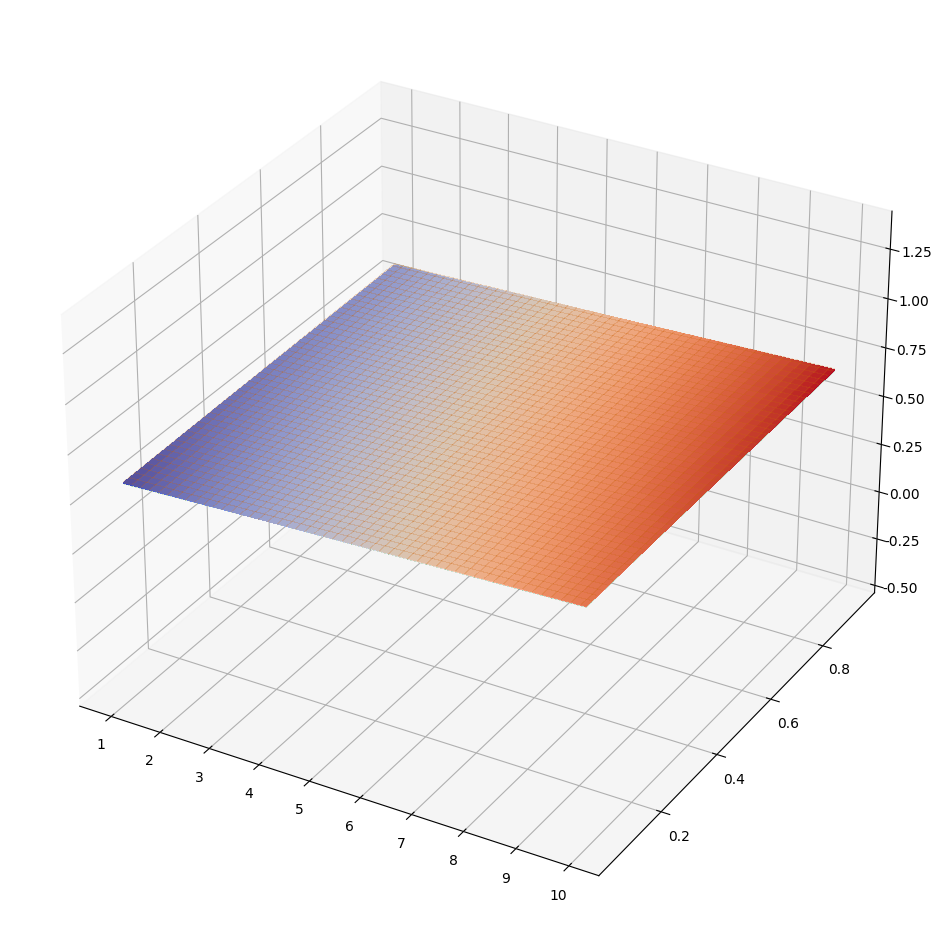

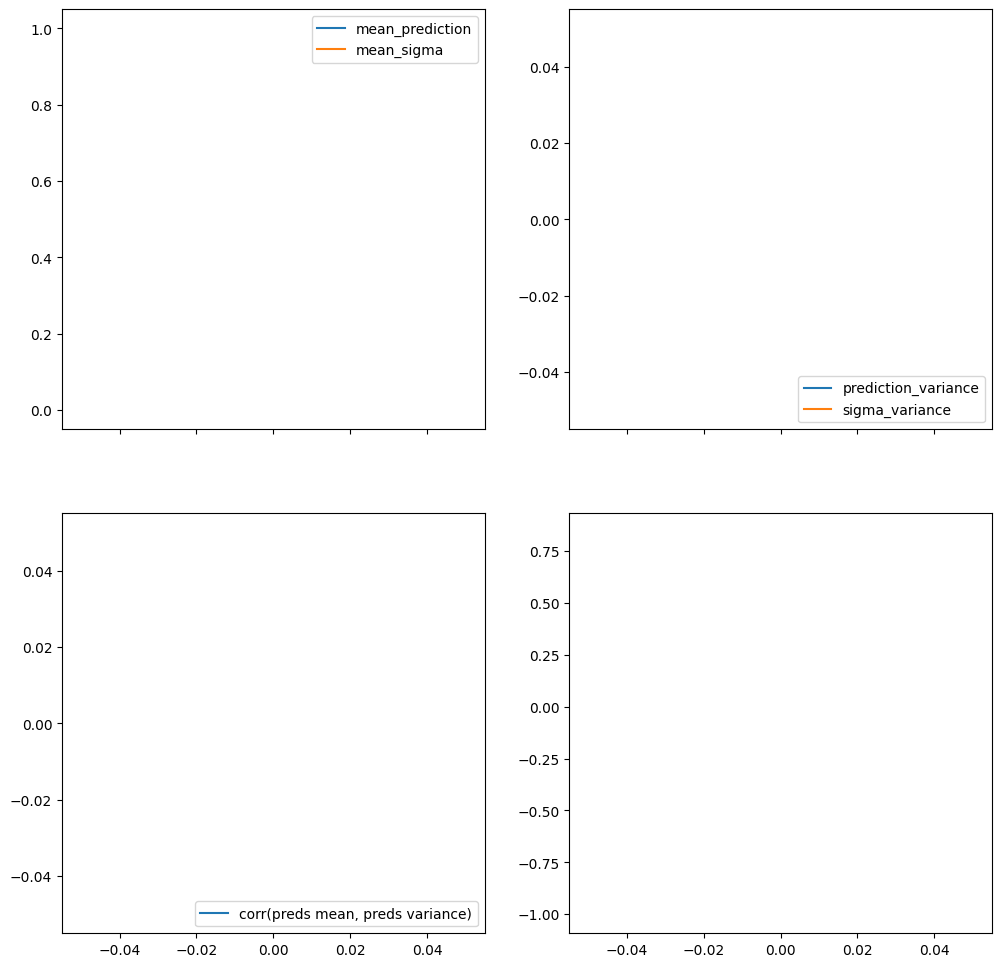

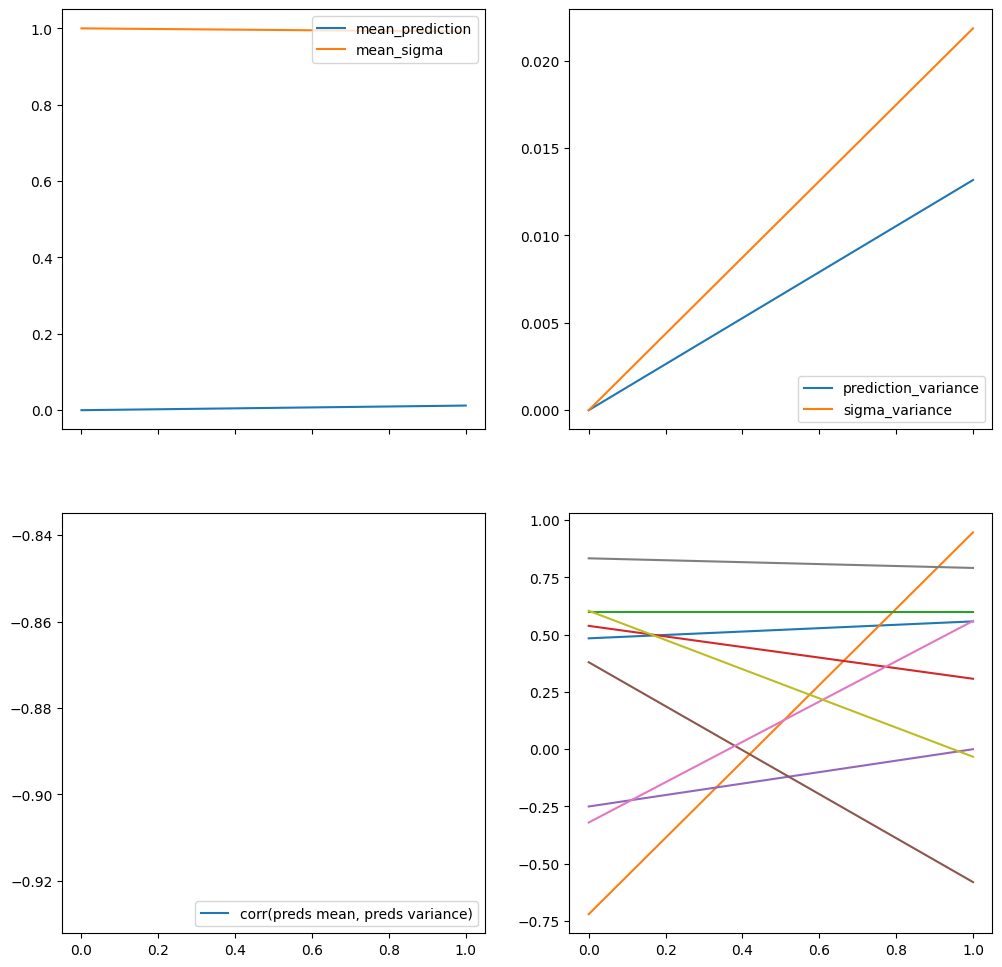

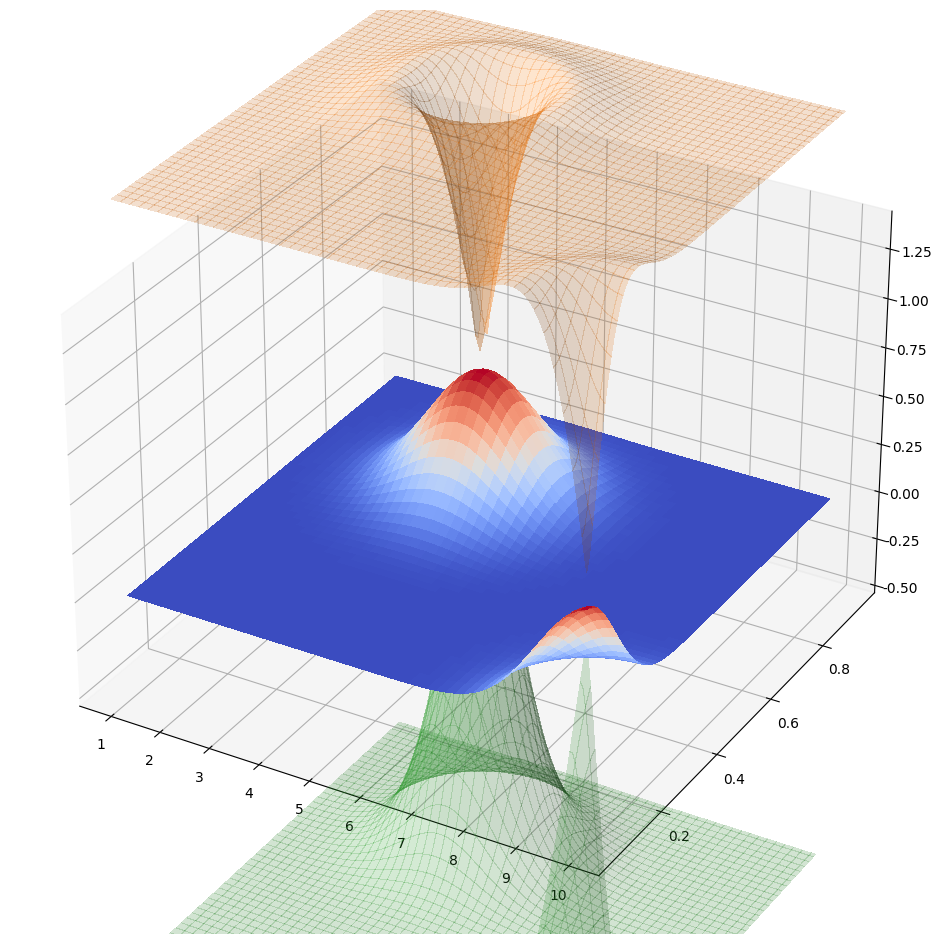

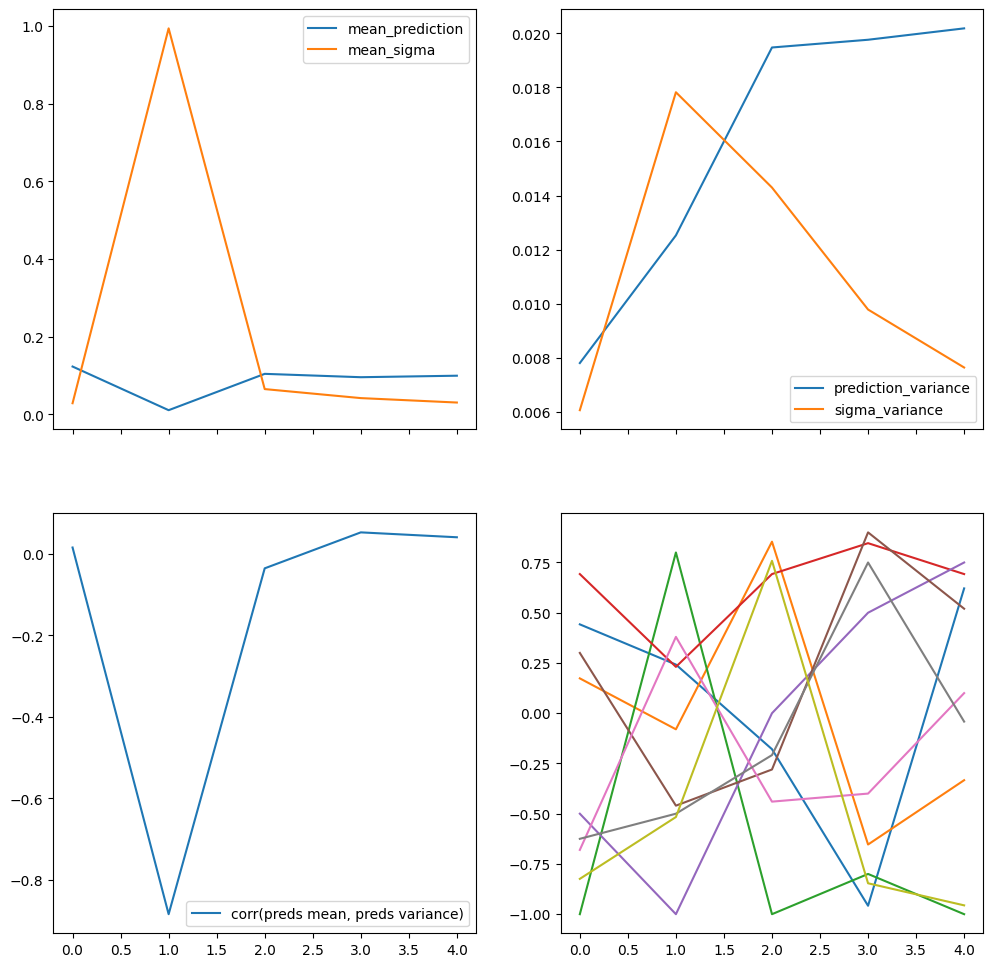

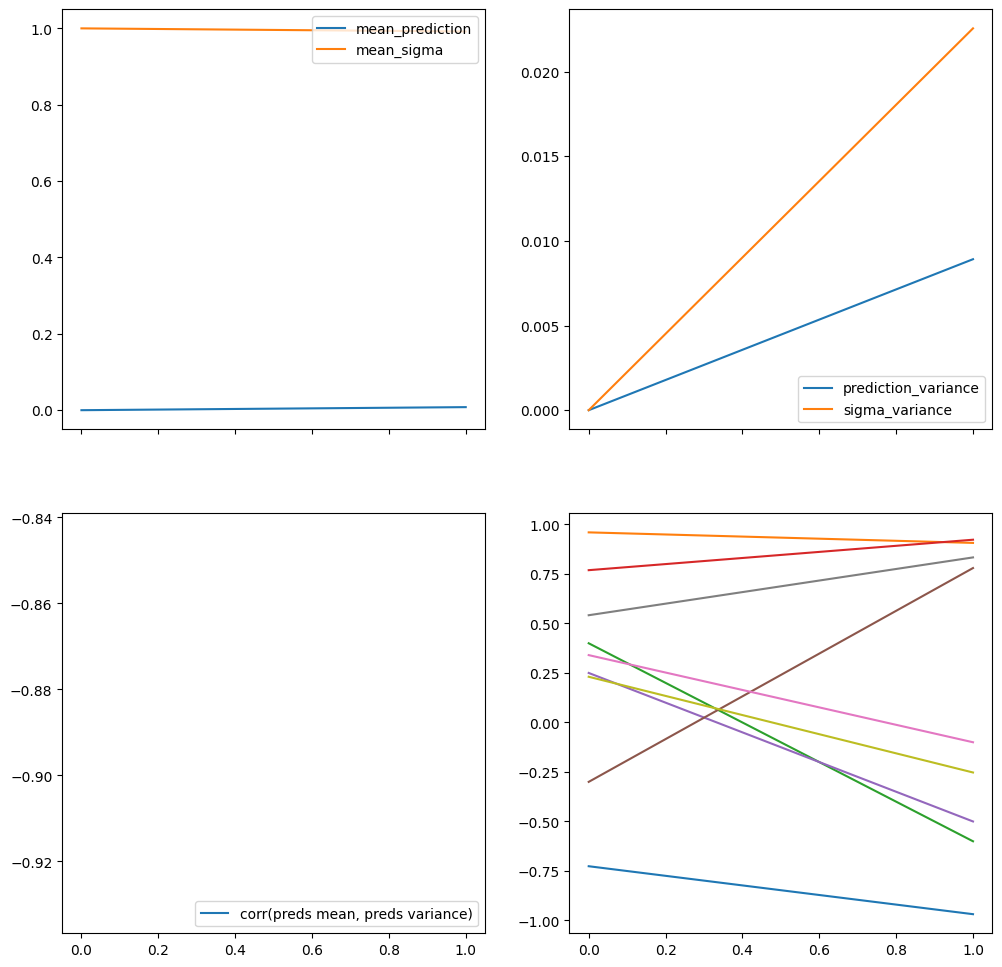

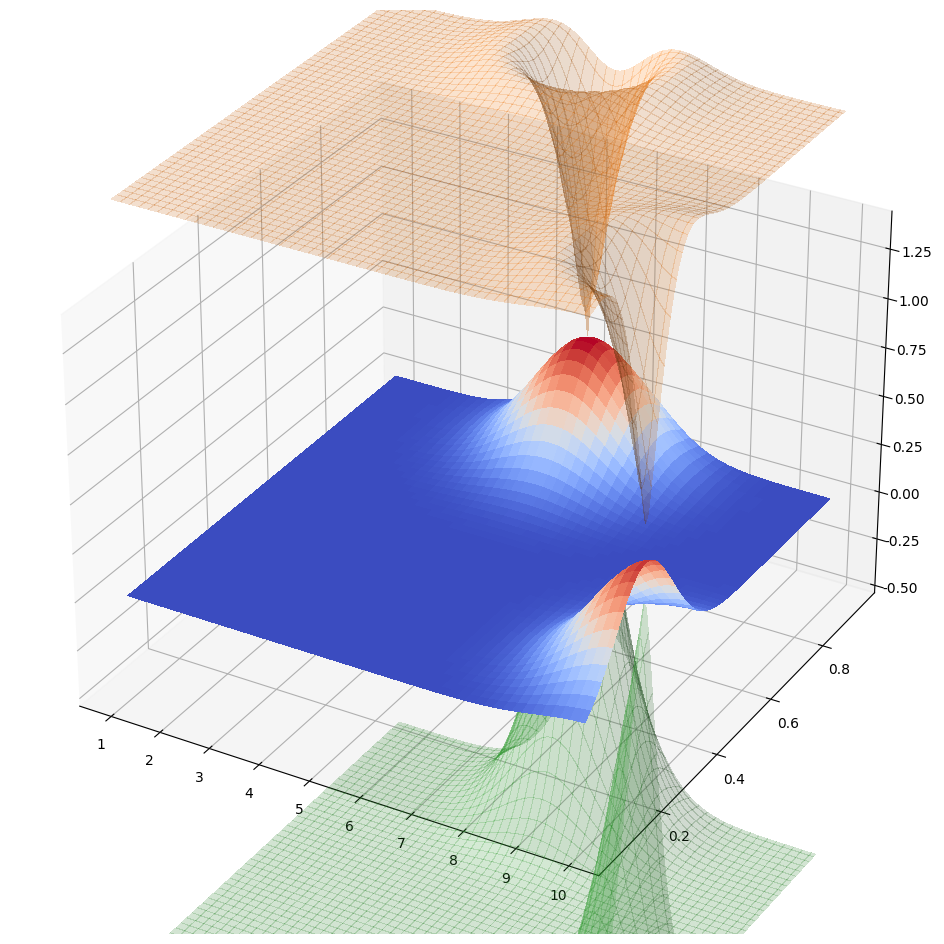

In [17]:
gec.save_figs("./test")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.categorical_hyperparameters[:1] + gec.real_hyperparameters)
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=100)
gs.fit(X_reweighted, y_reweighted)

In [ ]:
X_eval, y_eval = X_reweighted, y_reweighted
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X_eval, y_eval, cv=5))
knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X_eval, y_eval, cv=5))
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X_eval, y_eval, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")
